## Observation System Simulation Experiments in the Atlantic Ocean for enhanced surface ocean pCO$_2$ reconstructions.

Laura Cimoli (ICCS, University of Cambridge)<br>
**Anna Denvil-Sommer (NCAS, University of Reading)**

Modified by LC, July 2025<br>
Original code by ADS. See also ICCS summer school 2024.

&emsp;

#### Outline

1. [Introduction](#1-introduction)
2. [Data](#2-data)
3. [Features description](#3-features-description-and-preprocessing)
4. [Exercise](#4-exercise)
- 4.a [Read and visualize data](#a-read-and-visualise-data)
- 4.b. [Define the neural network model, train the model and visualise loss function](#b.-Define-the-neural-network-model,-train-the-model-and-visualise-loss-function)
- 4.c [Validate the model](#c.-Validate-the-model)
- 4.d [Estimate and visualise model's statistic](#d.-Estimate-and-visualise-model's-statistic)
 
5. [Conclusion](#5.-Conclusion)
6. [References](#6.-References)

## 1. Introduction
[See also presentation](link will be here)

- PROBLEM: Sparse observations of ocean surface pCO$_2$, in space and time
- QUESTION TO ANSWER: Where and how many additional observations do we need to capture accurately the variability of the pCO2 full seasonal cycle?
- SOLUTION: Identify best sampling strategy by using ocean model outputs to create pseudo-observations and Machine Learning to explore different design options of the future observing system distribution

&emsp;

The ocean is a major sink of anthropogenic CO$_2$. For the period 2010–2019 the ocean uptake was 2.5 ± 0.6 GtC yr−1, which corresponds to 25-30% of the cumulative atmospheric anthropogenic CO$_2$. Large discrepancies between model outputs and observation-based products limit our ability to monitor the global carbon cycle accurately. 

Air-sea CO$_2$ fluxes depend on the difference in CO$_2$ partial pressure (pCO$_2$) between the atmosphere and the ocean. The atmosphere being relatively well mixed, the main source of uncertainty in estimating air-sea CO$_2$ fluxes is related to the estimation of ocean surface CO$_2$ partial pressure.

Observations of pCO$_2$: compiled in [SOCAT](https://socat.info/).<br>
Data sources: most of the data comes from ship-based observations (automatic surface water sampling systems on board volunteering observing ships); observations are also collected with moorings and drifters.
(Note: In practice, pCO$_2$ is estimated from sea surface fugacity (fCO$_2$), which expresses the tendency of CO$_2$ to escape from the water; the partial pressure differs from fugacity by a factor of about 0.996, due to a slight non-ideal gas behavior of CO$_2$.)<br>
The data density is not homogenous, with southern latitudes being less well sampled in space and time, see figure below. 

<img src="SOCAT.png" width="70%">
<div style="text-align: center">Locations of moorings and tracks of ships and drifters for all data in SOCAT version 2023, observational dataset for 1957-2022.</div>

&emsp;

In contrast, measurements of oceanic *state* parameters (like temperature, salinity) are usually much denser in space and time (thanks to autonomous floats and satellite remote sensing data). This has motivated the development of methods that use the statistical relationship between *physical* and *biogeochemical* parameters for extrapolating sparse biogeochemical observations (such as  pCO$_2$) in space and time. In this context, Machine Learning (ML) approaches have gained a lot of attention over recent years. However, sparse data coverage and the lack of observations covering the full seasonal cycle challenge mapping methods and results in noisy reconstructions and disagreements between different models. The core problem is that we still need more observations.

How can we optimise pCO$_2$ sampling strategies and collect observations where they are most needed? <br>
In this exercise, we will show how ML approaches and output of ocean physical-biogeochemical models can be used to explore design options for a future Atlantic-scale observing system that would optimally combine data streams from various platforms and contribute to reducing the bias in reconstructed surface ocean pCO$_2$ fields and sea–air CO$_2$ fluxes. <br>
The use of NEMO/PISCES physical-biogeochemical model's outputs allows us create Argo floats pseudo-observations (i.e. synthetic observations) and identify the most critical regions that require more observations to provide a robust data-driven product based on ML approach. 

This exercise is based on the work Denvil-Sommer, A., Gehlen, M., and Vrac, M.: Observation system simulation experiments in the Atlantic Ocean for enhanced surface ocean pCO2 reconstructions, Ocean Sci., 17, 1011–1030, https://doi.org/10.5194/os-17-1011-2021, 2021.

## 2. Data

pCO$_2$ observations are available from:
- SOCAT database (which includes ship-based, mooring, and drifter observations);
- BGC (biogeochemical) Argo floats: some floats are equipped with pH sensors, which enable the computation of pCO$_2$ from pH and SST-based alkalinity.

When we subsample NEMO/PISCES to create synthetic data, we use the location of real observations from these two datasets. For the Argo floats: note that most of the floats currently deployed are 'core' Argo float, that measure T and S only and are not equipped with pH sensors. Here, we make the crude assumption that all floats are equipped with pH (~pCO$_2$) sensors. We use the distributions of physical Argo floats (2008–2011) from Gasparin et al. (2019). 

&emsp;

Here, we will evaluate the skills of three different observation system designs in reconstructing the surface ocean pCO$_2$. Ultimately, we want to know if we need to add any Argo floats, and if so where. This type of analysis is often called **Observation System Simulation Experiment**.

**Observation System Designs**:
1. SOCAT data only (i.e. moorings, ship track and drifters data only).
2. SOCAT data + 25% of Argo floats distributed over the whole Atlantic. This means that we are assuming that 25% of Argo floats over the whole Atlantic basin were equipped with pCO$_2$ sensors. The 25% choice comes from what was proposed in the original article Denvil-Sommer et al., 2021, where they also tested other %. See paper for more details.
3. SOCAT data + 25% of Argo float distributed over the South Atlantic only.
  
For all experiments, we reconstruct only **February month for the period 2008-2010**.

In this exercise, we use the data from NEMO/PISCES physical-biogeochemical model at 0.25degrees spatial resolution and 5-day temporal resolution. This configuration of the NEMO framework was implemented on a global tripolar grid. 

The geographical and time positions identified from the observational data are used to create pseudo-observations by sub-sampling NEMO/PISCES model output at sites of real-world observations. Thus, the positions of SOCAT, Argo floats and mooring stations were chosen over 5 d centred on the NEMO/PISCES date and sub-sampled on the model grid.

In Observational System Simulation Experiments the model represents a "truth" and is used both to train the ML model and to test its accuracy. 

## 3. Features description and preprocessing

Two sets of data are needed to test the machine learning method: a set of targets and a set of drivers. The targets represent the variables we are trying to reconstruct. The drivers represent the input variables to the ML method (here the physical and biogeochemical variables). 

### Model

The machine learning model used here is a Feed Forward Neural Network (FFNN). We are **NOT** going to describe the model architecture here, so take it a bit as a black-box model. For an introduction to NN, you can review the ICCS summer school 2023 or 2024 material.<br>

[Introduction to NN, ICCS summer school 2024 Part 1](https://www.youtube.com/watch?v=vdrEXV6b35g&list=PL3PByZO-B6dM4pw2AwLepEBsfDrly9L0w&index=5)
[Introduction to NN, ICCS summer school 2024 Part 2](https://www.youtube.com/watch?v=jQPTdRoBhOk&list=PL3PByZO-B6dM4pw2AwLepEBsfDrly9L0w&index=6)

[Introduction to NN, ICCS summer school 2023](https://www.youtube.com/watch?v=wtRWjw2J9Ro&list=PL3PByZO-B6dPTXGKpJ2P8KlaXjiO26NPU&index=14&t=22s)

### Target 

The target of FFNN is NEMO/PISCES pCO$_2$. 

### Predictors 

The standard set of variables known to represent the *physical* and *biogeochemical* drivers of surface ocean pCO$_2$ are sea surface salinity (SSS), sea surface temperature (SST), mixed layer depth (MLD), chlorophyll-a concentration (CHL), sea surface height (SSH) and the atmospheric CO$_2$ mole fraction ($x CO_{2, atm}$ ) (Takahashi et al., 2009; Landschützer et al., 2013). These variables and their anomalies are proposed as input variables (or predictors) for training ML algorithms. Additionally, we use geographical coordinates, latitude and longitude, as predictors.

All data are taken from the NEMO/PISCES model at the position of SOCAT or ARGO float in February 2008-2010. 

### Normalization

We log-transformed MLD and CHL data because of their skewed distribution. It is also worth noting that all datasets (including target) need to be normalized (i.e., centered to zero-mean and reduced to unit standard deviation). Normalization ensures that all predictors fall within a comparable range and avoids giving more weight to predictors with large variability ranges (Kallache et al., 2011), example:

$$SSS_n =\frac{SSS-\overline{SSS}}{std(SSS)}.$$

Latitude and longitude are also normalized using following way:

$$lat_n = sin(lat * \pi/180)$$

$$long_{n,1} = sin(long * \pi/180)$$

$$long_{n,2} = cos(long * \pi/180)$$


All data sets are normalized and ready to be used in this exercise. We also provide mean and std values for pCO$_2$ to visualise the pCO$_2$ fields at the end of exercise. 

## 4. Exercise 

The following Python libraries are required to run the exercise successfully. 

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

## a. Read and visualise data

Before we define a Feed-Forward Neural Network we will have a look on the distribution of available datasets. The data are in .csv files and can be easily read in panda dataframes. 
We have two sets of data for each case: training and evaluation data. Training datasets are used to train the model, evaluation datasets are also used during training to evaluate the model at each iterative model step (namely, the model corrects its weights depending on the evaluation). These data were chosen regularly in time and space: every 4th grid point was kept for evaluation. 

In [2]:
# Prepare data
# Data_train, data_eval, pCO2_list_train, and pCO2_list_eval are pandas dataframes

#Data for SOCAT only experiments
data_train_SOCAT      = pd.read_csv('TrainingSetVarn_SOCAT_20082010_Feb.csv')  # Load training data here
data_eval_SOCAT       = pd.read_csv('EvaluationSetVarn_SOCAT_20082010_Feb.csv')  # Load evaluation data here
pCO2_list_train_SOCAT = pd.read_csv('TrainingSetpCO2_SOCAT_20082010_Feb.csv')  # Load training targets here
pCO2_list_eval_SOCAT  = pd.read_csv('EvaluationSetpCO2_SOCAT_20082010_Feb.csv')  # Load evaluation targets here
data_train_SOCAT = data_train_SOCAT.drop(columns=['Unnamed: 0'])
data_eval_SOCAT = data_eval_SOCAT.drop(columns=['Unnamed: 0'])

#Data for SOCAT + ARGO 25% experiments
data_train_SOCAT_Argo25      = pd.read_csv('TrainingSetVarn_SOCAT_Argo25_20082010_Feb.csv')  # Load training data here
data_eval_SOCAT_Argo25       = pd.read_csv('EvaluationSetVarn_SOCAT_Argo25_20082010_Feb.csv')  # Load evaluation data here
pCO2_list_train_SOCAT_Argo25 = pd.read_csv('TrainingSetpCO2_SOCAT_Argo25_20082010_Feb.csv')  # Load training targets here
pCO2_list_eval_SOCAT_Argo25  = pd.read_csv('EvaluationSetpCO2_SOCAT_Argo25_20082010_Feb.csv')  # Load evaluation targets here
data_train_SOCAT_Argo25 = data_train_SOCAT_Argo25.drop(columns=['Unnamed: 0'])
data_eval_SOCAT_Argo25 = data_eval_SOCAT_Argo25.drop(columns=['Unnamed: 0'])

#Data for SOCAT + ARGO 25% in the South Atlantic basin experiments
data_train_SOCAT_Argo25S      = pd.read_csv('TrainingSetVarn_SOCAT_Argo25_South_20082010_Feb.csv')  # Load training data here
data_eval_SOCAT_Argo25S       = pd.read_csv('EvaluationSetVarn_SOCAT_Argo25_South_20082010_Feb.csv')  # Load evaluation data here
pCO2_list_train_SOCAT_Argo25S = pd.read_csv('TrainingSetpCO2_SOCAT_Argo25_South_20082010_Feb.csv')  # Load training targets herepCO2_list_eval_SOCAT_Argo25S  = pd.read_csv('EvaluationSetpCO2_SOCAT_Argo25_South_20082010_Feb.csv')  # Load evaluation targets here
pCO2_list_eval_SOCAT_Argo25S  = pd.read_csv('EvaluationSetpCO2_SOCAT_Argo25_South_20082010_Feb.csv')  # Load evaluation targets here
data_train_SOCAT_Argo25S = data_train_SOCAT_Argo25S.drop(columns=['Unnamed: 0'])
data_eval_SOCAT_Argo25S = data_eval_SOCAT_Argo25S.drop(columns=['Unnamed: 0'])

#Put data in tensor format to further use in ML model
data_train_tensor_SOCAT      = torch.tensor(data_train_SOCAT.values, dtype=torch.float32)
data_eval_tensor_SOCAT       = torch.tensor(data_eval_SOCAT.values, dtype=torch.float32)
pCO2_list_train_tensor_SOCAT = torch.tensor(pCO2_list_train_SOCAT['pCO2_n'].values, dtype=torch.float32)
pCO2_list_eval_tensor_SOCAT  = torch.tensor(pCO2_list_eval_SOCAT['pCO2_n'].values, dtype=torch.float32)

train_dataset_SOCAT = TensorDataset(data_train_tensor_SOCAT, pCO2_list_train_tensor_SOCAT)
eval_dataset_SOCAT  = TensorDataset(data_eval_tensor_SOCAT, pCO2_list_eval_tensor_SOCAT)

train_loader_SOCAT = DataLoader(train_dataset_SOCAT, batch_size=20, shuffle=True)
eval_loader_SOCAT  = DataLoader(eval_dataset_SOCAT, batch_size=20, shuffle=False)


data_train_tensor_SOCAT_Argo25      = torch.tensor(data_train_SOCAT_Argo25.values, dtype=torch.float32)
data_eval_tensor_SOCAT_Argo25       = torch.tensor(data_eval_SOCAT_Argo25.values, dtype=torch.float32)
pCO2_list_train_tensor_SOCAT_Argo25 = torch.tensor(pCO2_list_train_SOCAT_Argo25['pCO2_n'].values, dtype=torch.float32)
pCO2_list_eval_tensor_SOCAT_Argo25  = torch.tensor(pCO2_list_eval_SOCAT_Argo25['pCO2_n'].values, dtype=torch.float32)

train_dataset_SOCAT_Argo25 = TensorDataset(data_train_tensor_SOCAT_Argo25, pCO2_list_train_tensor_SOCAT_Argo25)
eval_dataset_SOCAT_Argo25  = TensorDataset(data_eval_tensor_SOCAT_Argo25, pCO2_list_eval_tensor_SOCAT_Argo25)

train_loader_SOCAT_Argo25 = DataLoader(train_dataset_SOCAT_Argo25, batch_size=20, shuffle=True)
eval_loader_SOCAT_Argo25  = DataLoader(eval_dataset_SOCAT_Argo25, batch_size=20, shuffle=False)


data_train_tensor_SOCAT_Argo25S      = torch.tensor(data_train_SOCAT_Argo25S.values, dtype=torch.float32)
data_eval_tensor_SOCAT_Argo25S       = torch.tensor(data_eval_SOCAT_Argo25S.values, dtype=torch.float32)
pCO2_list_train_tensor_SOCAT_Argo25S = torch.tensor(pCO2_list_train_SOCAT_Argo25S['pCO2_n'].values, dtype=torch.float32)
pCO2_list_eval_tensor_SOCAT_Argo25S  = torch.tensor(pCO2_list_eval_SOCAT_Argo25S['pCO2_n'].values, dtype=torch.float32)

train_dataset_SOCAT_Argo25S = TensorDataset(data_train_tensor_SOCAT_Argo25S, pCO2_list_train_tensor_SOCAT_Argo25S)
eval_dataset_SOCAT_Argo25S  = TensorDataset(data_eval_tensor_SOCAT_Argo25S, pCO2_list_eval_tensor_SOCAT_Argo25S)

train_loader_SOCAT_Argo25S = DataLoader(train_dataset_SOCAT_Argo25S, batch_size=20, shuffle=True)
eval_loader_SOCAT_Argo25S  = DataLoader(eval_dataset_SOCAT_Argo25S, batch_size=20, shuffle=False)


print(f'Number of points in SOCAT only training dataset: {len(data_train_SOCAT)}')
print(f'Number of points in SOCAT + 25% Argo training dataset: {len(data_train_SOCAT_Argo25)}')
print(f'Number of points in SOCAT + 25% Argo South Atlantic training dataset: {len(data_train_SOCAT_Argo25S)}')



Number of points in SOCAT only training dataset: 8954
Number of points in SOCAT + 25% Argo training dataset: 10293
Number of points in SOCAT + 25% Argo South Atlantic training dataset: 9628


&emsp;

Now we will visualise the distribution of three datasets for training and then three datasets for evaluation.  

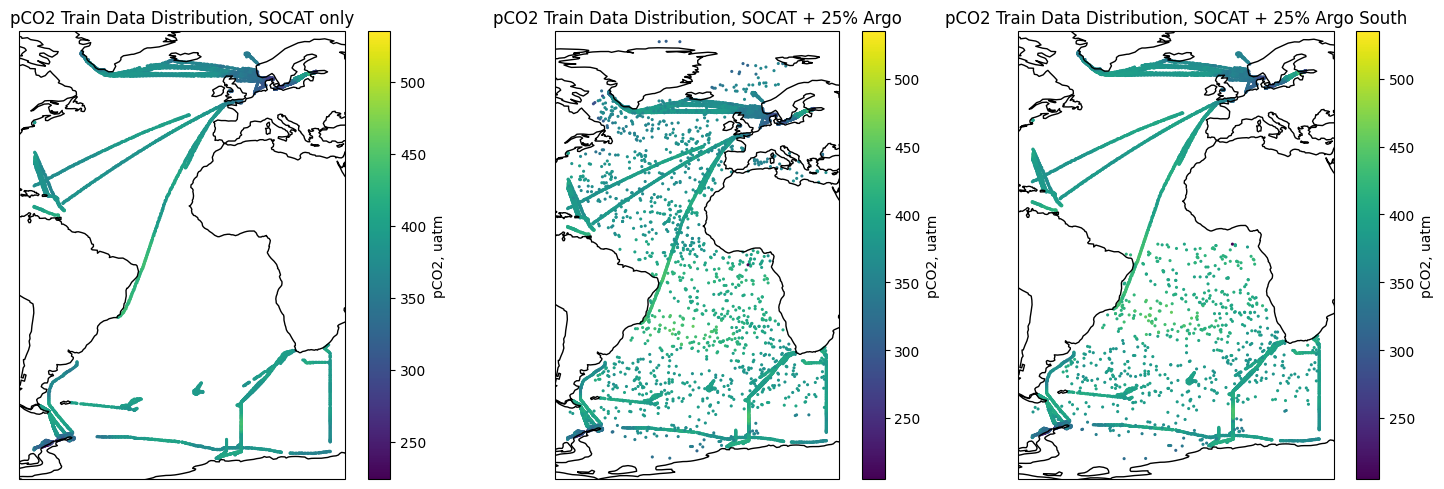

In [3]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Training Data SOCAT
ax = axes[0]
ax.coastlines()
sc = ax.scatter(pCO2_list_train_SOCAT['lon'], pCO2_list_train_SOCAT['lat'], c=pCO2_list_train_SOCAT['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Train Data Distribution, SOCAT only')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot 2: Training Data SOCAT + 25% Argo
ax = axes[1]
ax.coastlines()
sc = ax.scatter(pCO2_list_train_SOCAT_Argo25['lon'], pCO2_list_train_SOCAT_Argo25['lat'], c=pCO2_list_train_SOCAT_Argo25['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Train Data Distribution, SOCAT + 25% Argo')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot 3: Training Data SOCAT + 25% Argo South
ax = axes[2]
ax.coastlines()
sc = ax.scatter(pCO2_list_train_SOCAT_Argo25S['lon'], pCO2_list_train_SOCAT_Argo25S['lat'], c=pCO2_list_train_SOCAT_Argo25S['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Train Data Distribution, SOCAT + 25% Argo South')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


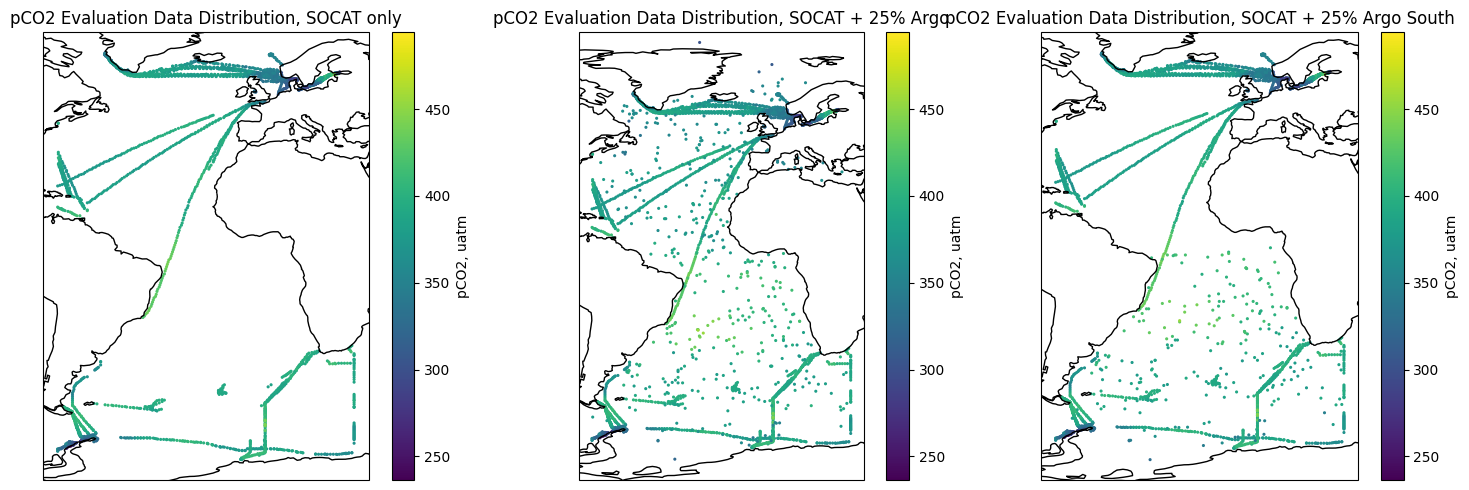

In [4]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

# Plot 1: Evaluation Data SOCAT
ax = axes[0]
ax.coastlines()
sc = ax.scatter(pCO2_list_eval_SOCAT['lon'], pCO2_list_eval_SOCAT['lat'], c=pCO2_list_eval_SOCAT['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Evaluation Data Distribution, SOCAT only')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot 2: Evaluation Data SCOAT + 25% Argo
ax = axes[1]
ax.coastlines()
sc = ax.scatter(pCO2_list_eval_SOCAT_Argo25['lon'], pCO2_list_eval_SOCAT_Argo25['lat'], c=pCO2_list_eval_SOCAT_Argo25['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Evaluation Data Distribution, SOCAT + 25% Argo')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Plot 3: Evaluation Data SOCAT + 25% Argo South
ax = axes[2]
ax.coastlines()
sc = ax.scatter(pCO2_list_eval_SOCAT_Argo25S['lon'], pCO2_list_eval_SOCAT_Argo25S['lat'], c=pCO2_list_eval_SOCAT_Argo25S['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree())
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('pCO2 Evaluation Data Distribution, SOCAT + 25% Argo South')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()


### Question:

Based on the distribution and number of points in the training datasets, which ML model do you think will perform best? 

&emsp;

## b. Define the neural network model, train the model and visualise loss function

## Feed-Forward Neural Network

To adjust the number of FFNN parameters/weights we followed the empirical rule that suggests limiting the number of parameters to the number of training data points divided by 10 to avoid overfitting (Amari et al., 1997). 
The FFNN has four layers (two hidden layers). The input layer has 15 input nodes (15 predictors) and 20 output nodes that represent the input for the first hidden layer. The first hidden layer has 25 output nodes, and the second hidden layer has 10 output nodes. 

We use Early Stopping to avoid overfitting (i.e. stop iteration when validation loss starts increasing). 

In [5]:
# Define the neural network model
class FeedForwardNN(nn.Module):
    def __init__(self):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(15, 20)
        self.tanh1 = nn.Tanh()
        self.fc2 = nn.Linear(20, 25)
        self.tanh2 = nn.Tanh()
        self.fc3 = nn.Linear(25, 10)
        self.tanh3 = nn.Tanh()
        self.fc4 = nn.Linear(10, 1)
        self.linear = nn.Identity()

    def forward(self, x):
        x = self.tanh1(self.fc1(x))
        x = self.tanh2(self.fc2(x))
        x = self.tanh3(self.fc3(x))
        x = self.linear(self.fc4(x))
        return x

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=30, verbose=False, delta=0):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''Saves model when validation loss decreases.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss

In [6]:
# Initialize the model, loss function, and optimizer
model_SOCAT = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_SOCAT.parameters(), lr=0.001, alpha=0.9, eps=1e-08, weight_decay=0.0)

# Calculate the number of parameters
total_params = sum(p.numel() for p in model_SOCAT.parameters())
print(f'Total number of parameters: {total_params}')

# Print a detailed summary of the parameters
for name, param in model_SOCAT.named_parameters():
    if param.requires_grad:
        print(f'{name}: {param.numel()} parameters')

Total number of parameters: 1116
fc1.weight: 300 parameters
fc1.bias: 20 parameters
fc2.weight: 500 parameters
fc2.bias: 25 parameters
fc3.weight: 250 parameters
fc3.bias: 10 parameters
fc4.weight: 10 parameters
fc4.bias: 1 parameters


&emsp;

### Questions:

How many parameters in total does the model have? Does the number correspond to the empirical rule for an optimal number of parameters?

After how many iterations will the model stop if there is not significant improvement during the training? 

&emsp;

Now we will train the model on the dataset that includes only SOCAT data.
To follow the evaluation of loss function during the training two list, 'train_losses_SOCAT' and 'val_losses_SOCAT', are created to store the values from train and evaluation datasets, respectively.

Note it might take a few minutes for this step to complete.

In [7]:
# Training the model
num_epochs = 1600
early_stopping = EarlyStopping(patience=30, verbose=True)

# Lists to store loss values
train_losses_SOCAT = []
val_losses_SOCAT = []

for epoch in range(num_epochs):
    model_SOCAT.train()
    train_loss_SOCAT = 0.0
    for batch_data, batch_target in train_loader_SOCAT:
        optimizer.zero_grad()
        outputs = model_SOCAT(batch_data)
        loss = criterion(outputs, batch_target.view(-1, 1))
        loss.backward()
        optimizer.step()        
        train_loss_SOCAT += loss.item()
            
    train_loss_SOCAT /= len(train_loader_SOCAT)
    train_losses_SOCAT.append(train_loss_SOCAT)

    model_SOCAT.eval()
    val_loss_SOCAT = 0.0
    with torch.no_grad():
        for batch_data, batch_target in eval_loader_SOCAT:
            outputs = model_SOCAT(batch_data)
            loss = criterion(outputs, batch_target.view(-1, 1))
            val_loss_SOCAT += loss.item()

    val_loss_SOCAT /= len(eval_loader_SOCAT)
    val_losses_SOCAT.append(val_loss_SOCAT)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss_SOCAT:.6f}')

    early_stopping(val_loss_SOCAT, model_SOCAT)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model_SOCAT.load_state_dict(torch.load('checkpoint.pt'))


Epoch 1, Validation Loss: 0.359927
Validation loss decreased (inf --> 0.359927).  Saving model ...
Epoch 2, Validation Loss: 0.300660
Validation loss decreased (0.359927 --> 0.300660).  Saving model ...
Epoch 3, Validation Loss: 0.262618
Validation loss decreased (0.300660 --> 0.262618).  Saving model ...
Epoch 4, Validation Loss: 0.226122
Validation loss decreased (0.262618 --> 0.226122).  Saving model ...
Epoch 5, Validation Loss: 0.221338
Validation loss decreased (0.226122 --> 0.221338).  Saving model ...
Epoch 6, Validation Loss: 0.195494
Validation loss decreased (0.221338 --> 0.195494).  Saving model ...
Epoch 7, Validation Loss: 0.186205
Validation loss decreased (0.195494 --> 0.186205).  Saving model ...
Epoch 8, Validation Loss: 0.232841
EarlyStopping counter: 1 out of 30
Epoch 9, Validation Loss: 0.190300
EarlyStopping counter: 2 out of 30
Epoch 10, Validation Loss: 0.161217
Validation loss decreased (0.186205 --> 0.161217).  Saving model ...
Epoch 11, Validation Loss: 0.219

<All keys matched successfully>

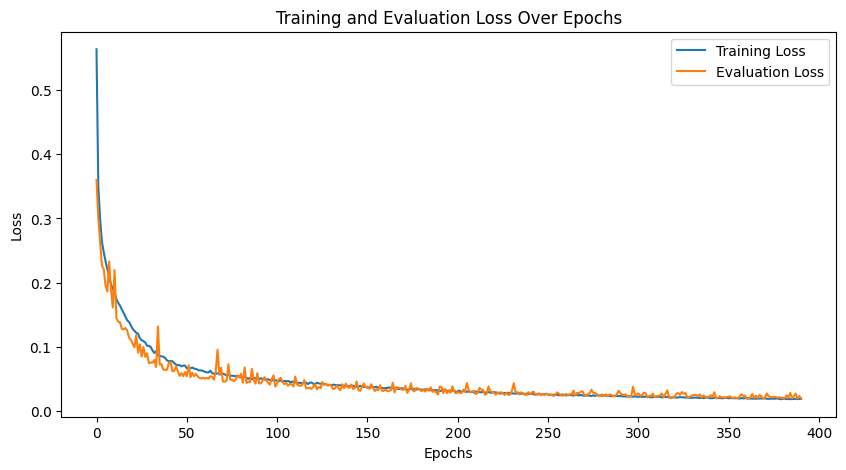

In [8]:
# Plotting the loss
plt.figure(figsize=(10,5))
plt.plot(train_losses_SOCAT, label='Training Loss')
plt.plot(val_losses_SOCAT, label='Evaluation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Evaluation Loss Over Epochs')
plt.show()

### Question:

How would you interpret this figure of loss function? What would you say about overfitting? 

&emsp;

Now we will repeat same training procedure for two other datasets that include data from Argo floats.

In [9]:
# Initialize the model, loss function, and optimizer
model_SOCAT_Argo25 = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_SOCAT_Argo25.parameters(), lr=0.001, alpha=0.9, eps=1e-08, weight_decay=0.0)

# Training the model
num_epochs = 1600
early_stopping = EarlyStopping(patience=30, verbose=True)

# Lists to store loss values
train_losses_SOCAT_Argo25 = []
val_losses_SOCAT_Argo25 = []

for epoch in range(num_epochs):
    model_SOCAT_Argo25.train()
    train_loss_SOCAT_Argo25 = 0.0
    for batch_data, batch_target in train_loader_SOCAT_Argo25:
        optimizer.zero_grad()
        outputs = model_SOCAT_Argo25(batch_data)
        loss = criterion(outputs, batch_target.view(-1, 1))
        loss.backward()
        optimizer.step()        
        train_loss_SOCAT_Argo25 += loss.item()
            
    train_loss_SOCAT_Argo25 /= len(train_loader_SOCAT_Argo25)
    train_losses_SOCAT_Argo25.append(train_loss_SOCAT_Argo25)

    model_SOCAT_Argo25.eval()
    val_loss_SOCAT_Argo25 = 0.0
    with torch.no_grad():
        for batch_data, batch_target in eval_loader_SOCAT_Argo25:
            outputs = model_SOCAT_Argo25(batch_data)
            loss = criterion(outputs, batch_target.view(-1, 1))
            val_loss_SOCAT_Argo25 += loss.item()

    val_loss_SOCAT_Argo25 /= len(eval_loader_SOCAT_Argo25)
    val_losses_SOCAT_Argo25.append(val_loss_SOCAT_Argo25)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss_SOCAT_Argo25:.6f}')

    early_stopping(val_loss_SOCAT_Argo25, model_SOCAT_Argo25)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model_SOCAT_Argo25.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1, Validation Loss: 0.353830
Validation loss decreased (inf --> 0.353830).  Saving model ...
Epoch 2, Validation Loss: 0.280463
Validation loss decreased (0.353830 --> 0.280463).  Saving model ...
Epoch 3, Validation Loss: 0.268136
Validation loss decreased (0.280463 --> 0.268136).  Saving model ...
Epoch 4, Validation Loss: 0.243126
Validation loss decreased (0.268136 --> 0.243126).  Saving model ...
Epoch 5, Validation Loss: 0.268084
EarlyStopping counter: 1 out of 30
Epoch 6, Validation Loss: 0.222208
Validation loss decreased (0.243126 --> 0.222208).  Saving model ...
Epoch 7, Validation Loss: 0.192141
Validation loss decreased (0.222208 --> 0.192141).  Saving model ...
Epoch 8, Validation Loss: 0.203083
EarlyStopping counter: 1 out of 30
Epoch 9, Validation Loss: 0.178292
Validation loss decreased (0.192141 --> 0.178292).  Saving model ...
Epoch 10, Validation Loss: 0.179990
EarlyStopping counter: 1 out of 30
Epoch 11, Validation Loss: 0.188835
EarlyStopping counter: 2 out o

<All keys matched successfully>

In [10]:
# Initialize the model, loss function, and optimizer
model_SOCAT_Argo25S = FeedForwardNN()
criterion = nn.MSELoss()
optimizer = optim.RMSprop(model_SOCAT_Argo25S.parameters(), lr=0.001, alpha=0.9, eps=1e-08, weight_decay=0.0)

# Training the model
num_epochs = 1600
early_stopping = EarlyStopping(patience=30, verbose=True)

# Lists to store loss values
train_losses_SOCAT_Argo25S = []
val_losses_SOCAT_Argo25S = []

for epoch in range(num_epochs):
    model_SOCAT_Argo25S.train()
    train_loss_SOCAT_Argo25S = 0.0
    for batch_data, batch_target in train_loader_SOCAT_Argo25S:
        optimizer.zero_grad()
        outputs = model_SOCAT_Argo25S(batch_data)
        loss = criterion(outputs, batch_target.view(-1, 1))
        loss.backward()
        optimizer.step()        
        train_loss_SOCAT_Argo25S += loss.item()
            
    train_loss_SOCAT_Argo25S /= len(train_loader_SOCAT_Argo25S)
    train_losses_SOCAT_Argo25S.append(train_loss_SOCAT_Argo25S)

    model_SOCAT_Argo25S.eval()
    val_loss_SOCAT_Argo25S = 0.0
    with torch.no_grad():
        for batch_data, batch_target in eval_loader_SOCAT_Argo25S:
            outputs = model_SOCAT_Argo25S(batch_data)
            loss = criterion(outputs, batch_target.view(-1, 1))
            val_loss_SOCAT_Argo25S += loss.item()

    val_loss_SOCAT_Argo25S /= len(eval_loader_SOCAT_Argo25S)
    val_losses_SOCAT_Argo25S.append(val_loss_SOCAT_Argo25S)
    print(f'Epoch {epoch+1}, Validation Loss: {val_loss_SOCAT_Argo25S:.6f}')

    early_stopping(val_loss_SOCAT_Argo25S, model_SOCAT_Argo25S)
    if early_stopping.early_stop:
        print("Early stopping")
        break

# Load the best model
model_SOCAT_Argo25S.load_state_dict(torch.load('checkpoint.pt'))

Epoch 1, Validation Loss: 0.384823
Validation loss decreased (inf --> 0.384823).  Saving model ...
Epoch 2, Validation Loss: 0.288856
Validation loss decreased (0.384823 --> 0.288856).  Saving model ...
Epoch 3, Validation Loss: 0.370712
EarlyStopping counter: 1 out of 30
Epoch 4, Validation Loss: 0.236130
Validation loss decreased (0.288856 --> 0.236130).  Saving model ...
Epoch 5, Validation Loss: 0.214464
Validation loss decreased (0.236130 --> 0.214464).  Saving model ...
Epoch 6, Validation Loss: 0.210346
Validation loss decreased (0.214464 --> 0.210346).  Saving model ...
Epoch 7, Validation Loss: 0.207443
Validation loss decreased (0.210346 --> 0.207443).  Saving model ...
Epoch 8, Validation Loss: 0.156809
Validation loss decreased (0.207443 --> 0.156809).  Saving model ...
Epoch 9, Validation Loss: 0.153266
Validation loss decreased (0.156809 --> 0.153266).  Saving model ...
Epoch 10, Validation Loss: 0.188214
EarlyStopping counter: 1 out of 30
Epoch 11, Validation Loss: 0.147

<All keys matched successfully>

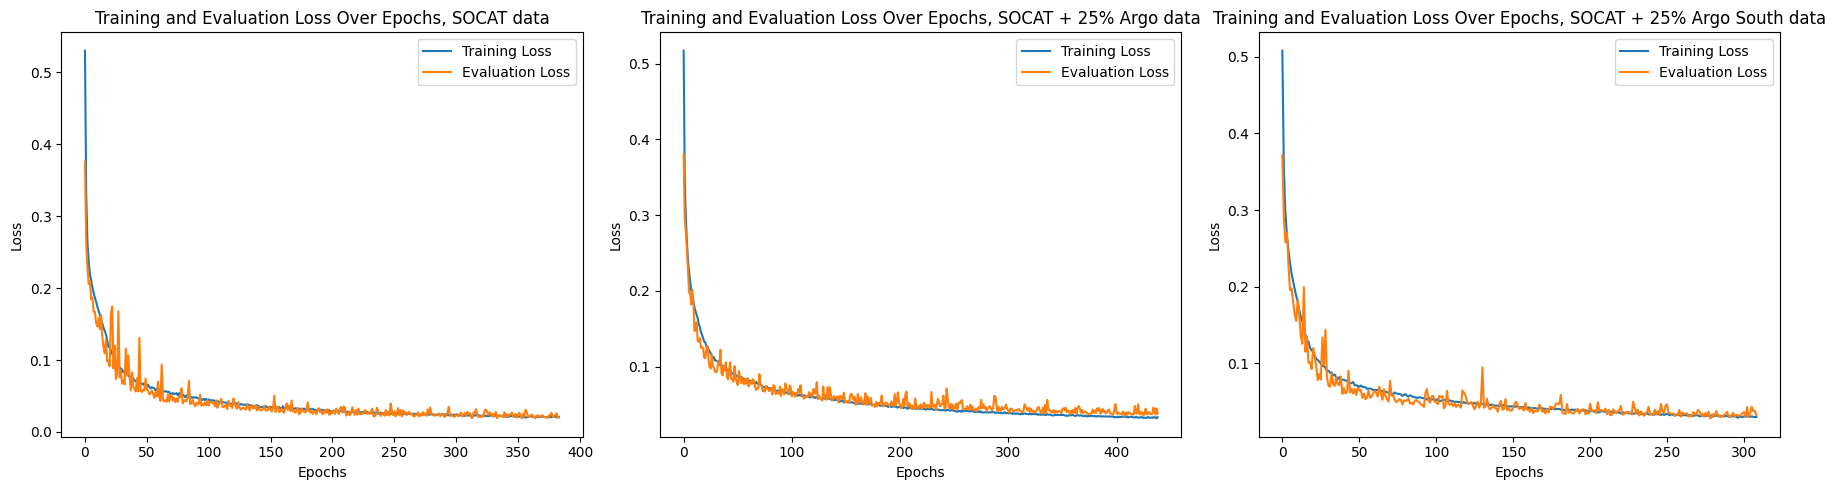

In [11]:
# Create a figure with three subplots, three figures of loss functions
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: SOCAT Data
ax = axes[0]
ax.plot(train_losses_SOCAT, label='Training Loss')
ax.plot(val_losses_SOCAT, label='Evaluation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training and Evaluation Loss Over Epochs, SOCAT data')

# Plot 2: SOCAT + 25% Argo Data
ax = axes[1]
ax.plot(train_losses_SOCAT_Argo25, label='Training Loss')
ax.plot(val_losses_SOCAT_Argo25, label='Evaluation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training and Evaluation Loss Over Epochs, SOCAT + 25% Argo data')

# Plot 3: SOCAT + 25% Argo South Data
ax = axes[2]
ax.plot(train_losses_SOCAT_Argo25S, label='Training Loss')
ax.plot(val_losses_SOCAT_Argo25S, label='Evaluation Loss')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')
ax.legend()
ax.set_title('Training and Evaluation Loss Over Epochs, SOCAT + 25% Argo South data')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

&emsp;

## c. Validate the model

Trained models will be evaluated now on the validation data. Validation data consists of pCO$_2$ concentrations from NEMO/PISCES for the period of February 2008-1010. The reconstructed pCO$_2$ fields are stored in 'recon_pCO2_SOCAT', 'recon_pCO2_SOCAT_Argo25','recon_pCO2_SOCAT_Argo25S'.

In [11]:
# Evaluate the model
data_val_SOCAT      = pd.read_csv('Prediction_Variables_normSOCAT_Feb.csv')  # Load validation data here
pCO2_list_val_SOCAT = pd.read_csv('Prediction_pCO2_normSOCAT_Feb.csv')  # Load validation targets here
data_val_SOCAT      = data_val_SOCAT.drop(columns=['Unnamed: 0'])

data_val_tensor_SOCAT      = torch.tensor(data_val_SOCAT.values, dtype=torch.float32)
pCO2_list_val_tensor_SOCAT = torch.tensor(pCO2_list_val_SOCAT['pCO2_n'].values, dtype=torch.float32)

val_dataset_SOCAT = TensorDataset(data_val_tensor_SOCAT, pCO2_list_val_tensor_SOCAT)
val_loader_SOCAT  = DataLoader(val_dataset_SOCAT, batch_size=20, shuffle=False)

model_SOCAT.eval()
val_loss_SOCAT = 0.0
recon_pCO2_SOCAT = []
target_pCO2_SOCAT = []
with torch.no_grad():
    for batch_data, batch_target in val_loader_SOCAT:
        outputs = model_SOCAT(batch_data)
        recon_pCO2_SOCAT.append(outputs)
        target_pCO2_SOCAT.append(batch_target)
        loss = criterion(outputs, batch_target.view(-1, 1))
        val_loss_SOCAT += loss.item()

val_loss_SOCAT /= len(val_loader_SOCAT)
print(f'Validation Loss SOCAT: {val_loss_SOCAT:.6f}')


# Evaluate the model

model_SOCAT_Argo25.eval()
val_loss_SOCAT_Argo25 = 0.0
recon_pCO2_SOCAT_Argo25 = []
target_pCO2_SOCAT_Argo25 = []
with torch.no_grad():
    for batch_data, batch_target in val_loader_SOCAT:
        outputs = model_SOCAT_Argo25(batch_data)
        recon_pCO2_SOCAT_Argo25.append(outputs)
        target_pCO2_SOCAT_Argo25.append(batch_target)
        loss = criterion(outputs, batch_target.view(-1, 1))
        val_loss_SOCAT_Argo25 += loss.item()

val_loss_SOCAT_Argo25 /= len(val_loader_SOCAT)
print(f'Validation Loss SOCAT + 25% Argo: {val_loss_SOCAT_Argo25:.6f}')


# Evaluate the model

model_SOCAT_Argo25S.eval()
val_loss_SOCAT_Argo25S = 0.0
recon_pCO2_SOCAT_Argo25S = []
target_pCO2_SOCAT_Argo25S = []
with torch.no_grad():
    for batch_data, batch_target in val_loader_SOCAT:
        outputs = model_SOCAT_Argo25S(batch_data)
        recon_pCO2_SOCAT_Argo25S.append(outputs)
        target_pCO2_SOCAT_Argo25S.append(batch_target)
        loss = criterion(outputs, batch_target.view(-1, 1))
        val_loss_SOCAT_Argo25S += loss.item()

val_loss_SOCAT_Argo25S /= len(val_loader_SOCAT)
print(f'Validation Loss SOCAT + 25% Argo South: {val_loss_SOCAT_Argo25S:.6f}')

Validation Loss SOCAT: 0.705455
Validation Loss SOCAT + 25% Argo: 0.422514
Validation Loss SOCAT + 25% Argo South: 0.509764


## Question:

What would you conclude about the accuracy of these three models? 

&emsp;

## d. Estimate and visualise model's statistic

It is important to plot the reconstructed fields and evaluate the accuracy regionally as the averaged statistics can be good as a esult of error compensation. In this section we will plot the mean field of three reconstructed $pCO_2$ values, their standard deviation (STD), mean differences and correlation coefficients between reconstructed fields and NEMO/PISCES.

### Hints: 
the output of FFNN is normalized $pCO_2$ values, to work with $pCO_2$ in $\mu$atm we need to convert it back using mean and std values that can be found in the original files. 

In [12]:
# concatenate the FFNN output and target values of pCO2
result_SOCAT = torch.cat(recon_pCO2_SOCAT, dim=0) 
result_target_SOCAT = torch.cat(target_pCO2_SOCAT) 

result_SOCAT_Argo25 = torch.cat(recon_pCO2_SOCAT_Argo25, dim=0) 

result_SOCAT_Argo25S = torch.cat(recon_pCO2_SOCAT_Argo25S, dim=0) 

In [13]:
#create a new dataframe with pCO2 values from NEMO/PISCES (pCO2) and three outputs from three ML experiments in uatm
pCO2_results = pCO2_list_val_SOCAT[['year','month','day','lat','lon','pCO2']]

In [14]:
pCO2_results['pCO2_SOCAT'] = (result_SOCAT.numpy() * pCO2_list_train_SOCAT['pCO2_std'][0] + pCO2_list_train_SOCAT['pCO2_mean'][0]).flatten()
pCO2_results['pCO2_SOCAT_Argo25'] = (result_SOCAT_Argo25.numpy() * pCO2_list_train_SOCAT_Argo25['pCO2_std'][0] + pCO2_list_train_SOCAT_Argo25['pCO2_mean'][0]).flatten()
pCO2_results['pCO2_SOCAT_Argo25S'] = (result_SOCAT_Argo25S.numpy() * pCO2_list_train_SOCAT_Argo25S['pCO2_std'][0] + pCO2_list_train_SOCAT_Argo25S['pCO2_mean'][0]).flatten()

/var/folders/xj/fth7_l092dx3v6bh3vkzm6vh0000gr/T/ipykernel_75529/2242934653.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pCO2_results['pCO2_SOCAT'] = (result_SOCAT.numpy() * pCO2_list_train_SOCAT['pCO2_std'][0] + pCO2_list_train_SOCAT['pCO2_mean'][0]).flatten()
/var/folders/xj/fth7_l092dx3v6bh3vkzm6vh0000gr/T/ipykernel_75529/2242934653.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pCO2_results['pCO2_SOCAT_Argo25'] = (result_SOCAT_Argo25.numpy() * pCO2_list_train_SOCAT_Argo25['pCO2_std'][0] + pC

In [15]:
#estimate the difference between NEMO/PISCES and FFNN outputs
pCO2_results['Diff_SOCAT'] = pCO2_results['pCO2'] - pCO2_results['pCO2_SOCAT']
pCO2_results['Diff_SOCAT_Argo25'] = pCO2_results['pCO2'] - pCO2_results['pCO2_SOCAT_Argo25']
pCO2_results['Diff_SOCAT_Argo25S'] = pCO2_results['pCO2'] - pCO2_results['pCO2_SOCAT_Argo25S']


In [16]:
#estimate mean values of dataframe pCO2_results over each grid point
pCO2_results_mean = pCO2_results.groupby(['lat','lon']).mean().reset_index()

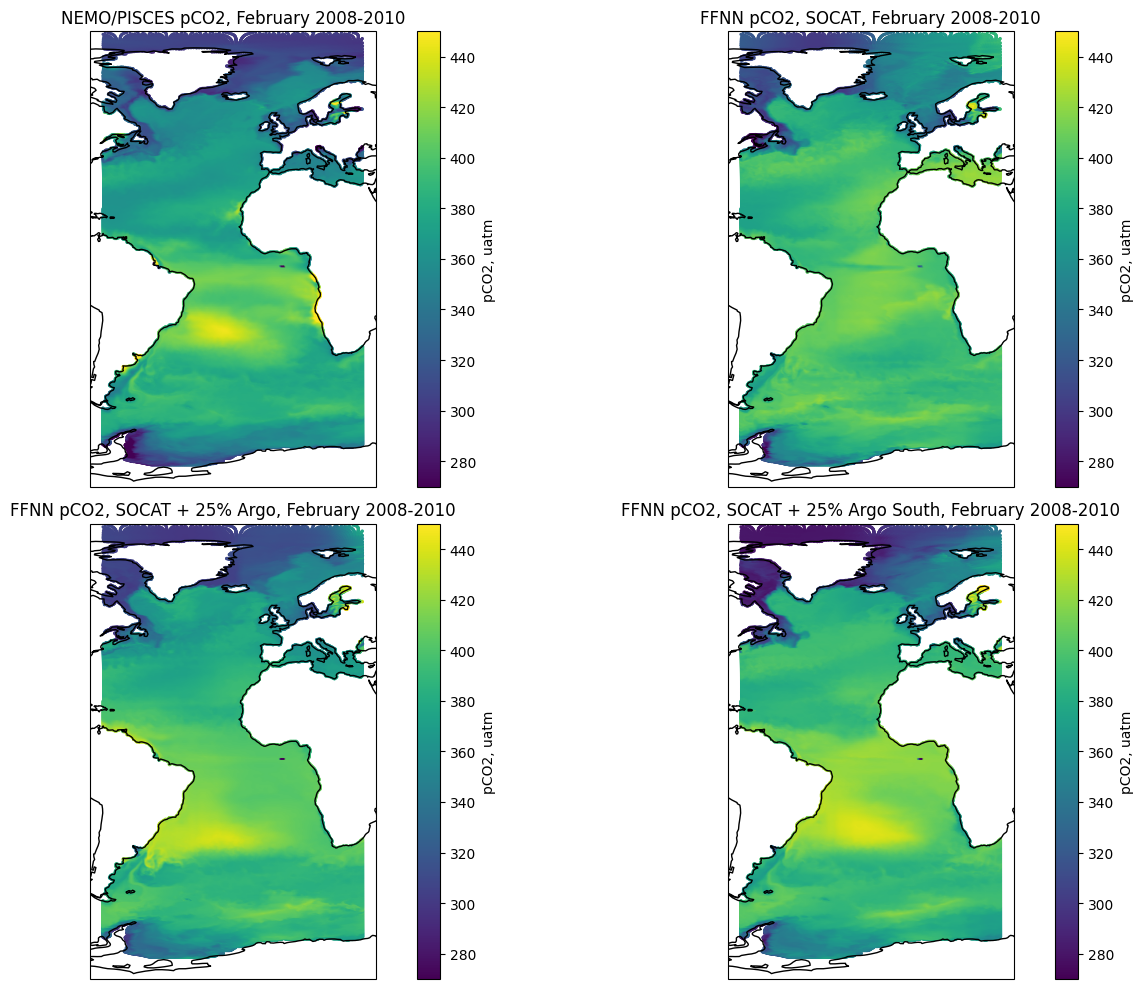

In [17]:
#plot mean values of NEMO/PISCES and three FFNN outputs for February 2008-2010
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = 450.
vmax = 300.

# Subplot 1
ax = axes[0, 0]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['pCO2'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES pCO2, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 2
ax = axes[0, 1]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['pCO2_SOCAT'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('FFNN pCO2, SOCAT, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 3
ax = axes[1, 0]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['pCO2_SOCAT_Argo25'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('FFNN pCO2, SOCAT + 25% Argo, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 4
ax = axes[1, 1]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['pCO2_SOCAT_Argo25S'], cmap='viridis', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('FFNN pCO2, SOCAT + 25% Argo South, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Question:

What regions show the largest differences?

&emsp;

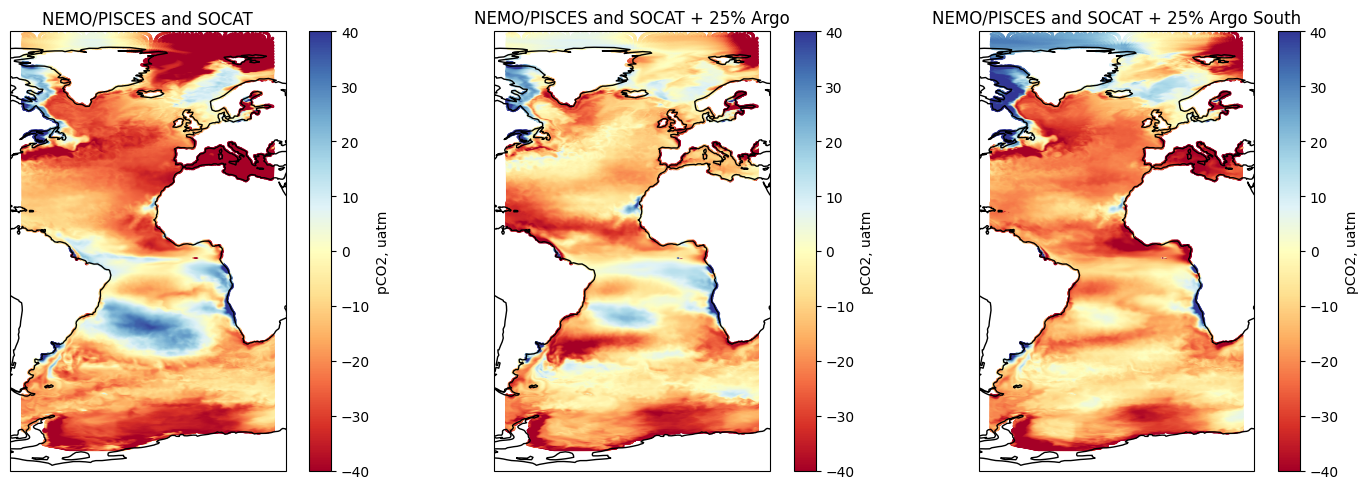

In [18]:
#plot mean values of differences betwwen NEMO/PISCES and three FFNN outputs for February 2008-2010
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = -40.
vmax = 40.

# Subplot 1
ax = axes[0]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Diff_SOCAT'], cmap='RdYlBu', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and SOCAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 2
ax = axes[1]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Diff_SOCAT_Argo25'], cmap='RdYlBu', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and SOCAT + 25% Argo')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 3
ax = axes[2]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Diff_SOCAT_Argo25S'], cmap='RdYlBu', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and SOCAT + 25% Argo South')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Question:

What would you say about the accuracy of each experiments? Do the data from Argo floats improve the reconstruction over the Atlantic Ocean?

&emsp;

In [19]:
#estimate std values of dataframe pCO2_results over each grid point
pCO2_results_std = pCO2_results.groupby(['lat','lon']).std().reset_index()

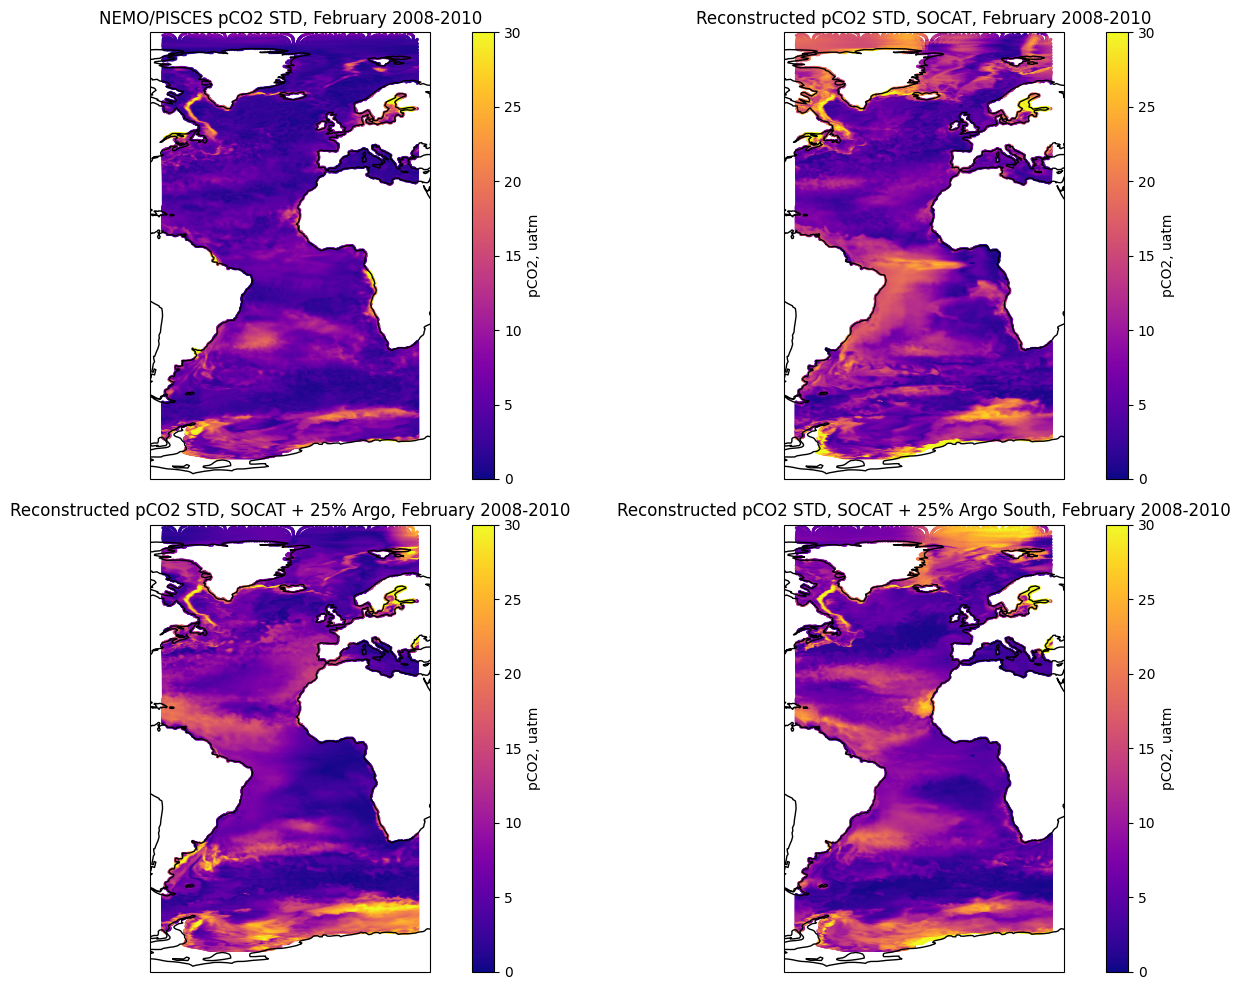

In [20]:
#plot std values of NEMO/PISCES and three FFNN outputs for February 2008-2010
fig, axes = plt.subplots(2, 2, figsize=(15, 10), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = 0.
vmax = 30.

# Subplot 1
ax = axes[0, 0]
ax.coastlines()
sc = ax.scatter(pCO2_results_std['lon'], pCO2_results_std['lat'], c=pCO2_results_std['pCO2'], cmap='plasma', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES pCO2 STD, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 2
ax = axes[0, 1]
ax.coastlines()
sc = ax.scatter(pCO2_results_std['lon'], pCO2_results_std['lat'], c=pCO2_results_std['pCO2_SOCAT'], cmap='plasma', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('Reconstructed pCO2 STD, SOCAT, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 3
ax = axes[1, 0]
ax.coastlines()
sc = ax.scatter(pCO2_results_std['lon'], pCO2_results_std['lat'], c=pCO2_results_std['pCO2_SOCAT_Argo25'], cmap='plasma', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('Reconstructed pCO2 STD, SOCAT + 25% Argo, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 4
ax = axes[1, 1]
ax.coastlines()
sc = ax.scatter(pCO2_results_std['lon'], pCO2_results_std['lat'], c=pCO2_results_std['pCO2_SOCAT_Argo25S'], cmap='plasma', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('Reconstructed pCO2 STD, SOCAT + 25% Argo South, February 2008-2010')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

### Question:

Which experiment shows the spatial varibaility comparable to the NEMO/PISCES (first plot)? Using these plots and plots of mean differences what areas would you identify as needing further improvement? Why do these areas show poor statistics?  

&emsp;

In [21]:
#estimate correlation coefficients betwenn NEMO/PISCES and three FFNN outputs
pCO2_results_mean['Corr_SOCAT'] = pCO2_results.groupby(['lat','lon'])[['pCO2','pCO2_SOCAT']].corr().iloc[0::2,-1].reset_index()['pCO2_SOCAT']
pCO2_results_mean['Corr_SOCAT_Argo25'] = pCO2_results.groupby(['lat','lon'])[['pCO2','pCO2_SOCAT_Argo25']].corr().iloc[0::2,-1].reset_index()['pCO2_SOCAT_Argo25']
pCO2_results_mean['Corr_SOCAT_Argo25S'] = pCO2_results.groupby(['lat','lon'])[['pCO2','pCO2_SOCAT_Argo25S']].corr().iloc[0::2,-1].reset_index()['pCO2_SOCAT_Argo25S']


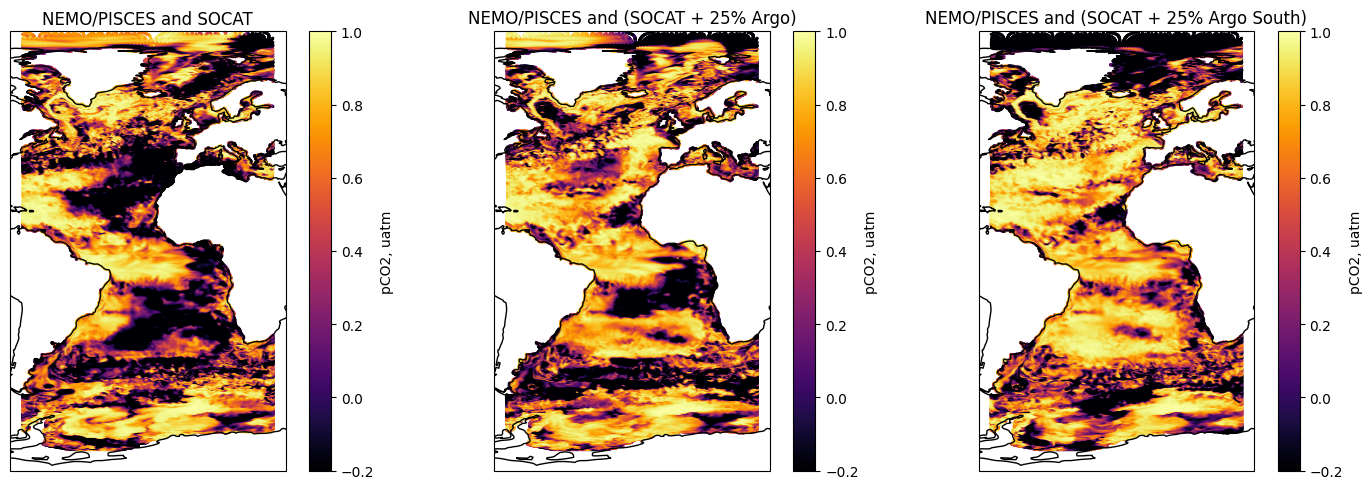

In [23]:
#plot correlation coefficients between NEMO/PISCES and three FFNN outputs for February 2008-2010
fig, axes = plt.subplots(1, 3, figsize=(15, 5), subplot_kw={'projection': ccrs.PlateCarree()})

vmin = -0.2
vmax = 1.

# Subplot 1
ax = axes[0]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Corr_SOCAT'], cmap='inferno', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and SOCAT')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 2
ax = axes[1]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Corr_SOCAT_Argo25'], cmap='inferno', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and (SOCAT + 25% Argo)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Subplot 3
ax = axes[2]
ax.coastlines()
sc = ax.scatter(pCO2_results_mean['lon'], pCO2_results_mean['lat'], c=pCO2_results_mean['Corr_SOCAT_Argo25S'], cmap='inferno', s=5, edgecolor='none', transform=ccrs.PlateCarree(), vmin=vmin, vmax=vmax)
plt.colorbar(sc, ax=ax, label='pCO2, uatm')
ax.set_title('NEMO/PISCES and (SOCAT + 25% Argo South)')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

&emsp;

### Question:

How would you interpret the correlation maps regarding our previous results? 

Which experiment would you advise as an optimal observational network of $pCO_2$ over the Atlantic Ocean? In your answer you should take into account the accuracy of the experiment's results as well as the realism of data distribution and possible cost of the realisation of this distribution.

&emsp;

## 5. Conclusion

In this practical session you learnt:

1. how to open, work and visualise the geographical data in panda dataframe format;

2. how to define a simple Feed-Forward Neural Network to reconstruct ocean surface pCO$_2$ using pyTorch library;

3. how to use early stopping function in you Neural Network model to prevent overfitting;

4. how to visualise model loss function to evaluate the training;

5. how to analyse the environmental data using statistics and plotting.

## 6. References

Amari, S., Murata, N., Müller, K.-R., Finke, M., and Yang, H. H.: Asymptotic Statistical Theory of Overtraining and Cross-Validation, IEEE T. Neural Networ., 8, 985–996, 1997. 

Bakker, D. C. E., Pfeil, B., Landa, C. S., Metzl, N., O'Brien, K. M., Olsen, A., Smith, K., Cosca, C., Harasawa, S., Jones, S. D., Nakaoka, S., Nojiri, Y., Schuster, U., Steinhoff, T., Sweeney, C., Takahashi, T., Tilbrook, B., Wada, C., Wanninkhof, R., Alin, S. R., Balestrini, C. F., Barbero, L., Bates, N. R., Bianchi, A. A., Bonou, F., Boutin, J., Bozec, Y., Burger, E. F., Cai, W.-J., Castle, R. D., Chen, L., Chierici, M., Currie, K., Evans, W., Featherstone, C., Feely, R. A., Fransson, A., Goyet, C., Greenwood, N., Gregor, L., Hankin, S., Hardman-Mountford, N. J., Harlay, J., Hauck, J., Hoppema, M., Humphreys, M. P., Hunt, C. W., Huss, B., Ibánhez, J. S. P., Johannessen, T., Keeling, R., Kitidis, V., Körtzinger, A., Kozyr, A., Krasakopoulou, E., Kuwata, A., Landschützer, P., Lauvset, S. K., Lefèvre, N., Lo Monaco, C., Manke, A., Mathis, J. T., Merlivat, L., Millero, F. J., Monteiro, P. M. S., Munro, D. R., Murata, A., Newberger, T., Omar, A. M., Ono, T., Paterson, K., Pearce, D., Pierrot, D., Robbins, L. L., Saito, S., Salisbury, J., Schlitzer, R., Schneider, B., Schweitzer, R., Sieger, R., Skjelvan, I., Sullivan, K. F., Sutherland, S. C., Sutton, A. J., Tadokoro, K., Telszewski, M., Tuma, M., van Heuven, S. M. A. C., Vandemark, D., Ward, B., Watson, A. J., and Xu, S.: A multi-decade record of high-quality fCO2 data in version 3 of the Surface Ocean CO2 Atlas (SOCAT), Earth Syst. Sci. Data, 8, 383–413, https://doi.org/10.5194/essd-8-383-2016, 2016. 

Gasparin, F., Guinehut, S., Mao, C., Mirouze, I., Rémy, E., King, R. R., Hamon, M., Reid, R., Storto, A., Le Traon, P. Y., and Martin, M. J.: Requirements for an integrated in situ Atlantic Ocean observing system from coordinated observing system simulation experiments, Front. Mar. Sci., 6, p. 83, https://doi.org/10.3389/fmars.2019.00083, 2019. 

Kallache, M., Vrac, M., Naveau, P., and Michelangeli, P.-A.: Non-stationary probabilistic downscaling of extreme precipitation, J. Geophys. Res., 116, D05113, https://doi.org/10.1029/2010JD014892, 2011. 

Landschützer, P., Gruber, N., Bakker, D. C. E., Schuster, U., Nakaoka, S., Payne, M. R., Sasse, T. P., and Zeng, J.: A neural network-based estimate of the seasonal to inter-annual variability of the Atlantic Ocean carbon sink, Biogeosciences, 10, 7793–7815, https://doi.org/10.5194/bg-10-7793-2013, 2013. 

Takahashi, T., Sutherland, S. C., Wanninkhof, R., Sweeney, C., Feely, R. A., Chipman, D. W., Hales, B., Friederich, G., Chavez, F., Sabine, C., Watson, A., Bakker, D. C. E., Schuster, U., Metzl, N., Yoshikawa-Inoue, H., Ishii, M., Midorikawa, T., Nojiri, Y., Körtzinger, A., Steinhoff, T., Hoppema, M., Olafsson, J., Arnarson, T. S., Tilbrook, B., Johannessen, T., Olsen, A., Bellerby, R., Wong, C. S., Delille, B., Bates, N. R., and de Baar, H. J. W.: Climatological mean and decadal change in surface ocean pCO2, and net sea-air CO2 flux over the global oceans, Deep.-Sea Res. Pt. II, 56, 554–577, https://doi.org/10.1016/j.dsr2.2008.12.009, 2009. 